# Including other Simulators as Actors

This example demonstrates how to integrate another python simulator such as the [windpowerlib](https://github.com/wind-python/windpowerlib) library to simulate a microgrid consisting of a data center and a
wind farm.

In [11]:
import vessim as vs
from windpowerlib import WindTurbine, ModelChain
import pandas as pd
import numpy as np

# Hotfix to execute asyncio in Jupyter
import nest_asyncio
nest_asyncio.apply()

some_date = "2024-07-17"

We configure wind turbines to calculate power output using synthetic weather
data. We define turbine data (Enercon E-126/4200, 135m hub height) and use a
list comprehension to create 30 turbines. Weather data for 24 hours is generated
with random wind speeds (5-15 km/h), temperatures (10-20°C), and a constant
roughness length of 0.1, organized in a pandas DataFrame. Using windpowerlib's
ModelChain, each turbine's power output is calculated based on the weather data.
The total power output from all 30 turbines is then summed.

In [12]:

turbine_data = {
    "turbine_type": "E-126/4200",
    "hub_height": 135,
}
number_turbines = 30
wind_turbines = [WindTurbine(**turbine_data) for _ in range(number_turbines)]
hours = 24

wind_speed = pd.Series(
    np.random.uniform(5, 15, hours),
    index=pd.date_range(start=some_date, periods=hours, freq="H"),
)
temperature = pd.Series(
    np.random.uniform(10, 20, hours),
    index=pd.date_range(start=some_date, periods=hours, freq="H"),
)
roughness = pd.Series(
    [0.1] * hours,
    index=pd.date_range(start=some_date, periods=hours, freq="H")
)

# the numbers are common reference heights
weather = pd.DataFrame(
    {
        ("wind_speed", 10): wind_speed,  # wind speed defined at height 10m
        ("temperature", 2): temperature,  # temperature at 2m
        ("roughness_length", 0): roughness,
    }
)

wind_power_output_all = sum(
    ModelChain(turbine).run_model(weather).power_output for turbine in wind_turbines
)

Using the pandas Dataframe from windpowerlib, we can now use a `HistoricalSignal` to create an `Actor` and add it to our microgrid.

In [13]:
environment = vs.Environment(sim_start=some_date)

monitor = vs.Monitor()
assert isinstance(wind_power_output_all, pd.Series)
environment.add_microgrid(
    actors=[
        vs.Actor(
            name="load",
            signal=vs.MockSignal(value=120000000), # 120 MW
        ),
        vs.Actor(
            name="wind_turbine",
            signal=vs.HistoricalSignal(wind_power_output_all)
        ),
    ],
    controllers=[monitor],
    step_size=3600,
)

environment.run(until=24 * 3600)  # 24h
monitor.to_csv("result.csv")

2024-09-03 09:49:56.166 | INFO     | mosaik.scenario:start:311 - Starting "Actor" as "load" ...
2024-09-03 09:49:56.170 | INFO     | mosaik.scenario:start:311 - Starting "Actor" as "wind_turbine" ...
2024-09-03 09:49:56.171 | INFO     | mosaik.scenario:start:311 - Starting "Grid" as "Grid-0" ...
2024-09-03 09:49:56.172 | INFO     | mosaik.scenario:start:311 - Starting "Controller" as "Monitor-2" ...
2024-09-03 09:49:56.173 | INFO     | mosaik.scenario:start:311 - Starting "Storage" as "Storage-0" ...
2024-09-03 09:49:56.175 | INFO     | mosaik.scenario:run:651 - Starting simulation.
100%|██████████| 86400/86400 [00:00<00:00, 1792118.50steps/s]
2024-09-03 09:49:56.226 | INFO     | mosaik.scenario:run:708 - Simulation finished successfully.


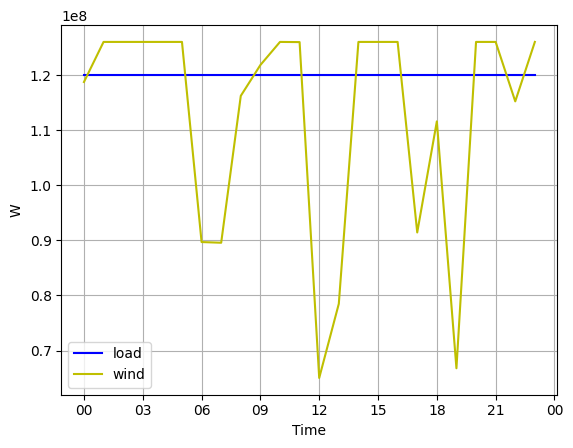

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv("result.csv", parse_dates=[0], index_col=0)
# divide e_delta by step size because e_delta is energy

fig, ax1 = plt.subplots()

ax1.plot(df.index, df["load.p"], color="b", label="load")
ax1.legend()
ax1.plot(df.index, df["wind_turbine.p"], color="y", label="wind")
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("W")

plt.show()